In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer

In [197]:
cardio = pd.read_csv('coris.csv')
pd.set_option('display.max_columns', None)

In [3]:
cardio.columns

Index(['row.names', 'sbp', 'tobacco', 'ldl', 'adiposity', 'famhist', 'typea',
       'obesity', 'alcohol', 'age', 'chd'],
      dtype='object')

In [198]:
cardio.drop('row.names', axis = 1, inplace = True)

In [5]:
cardio.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


In [199]:
cardio['famhist'] = cardio['famhist'].map({
    'Absent': 0, 'Present': 1
})

In [ ]:
import matplotlib.pyplot as plt
cardio.hist(bins = 20, figsize = (12,15))
plt.plot()

In [200]:
cardio['chd'].value_counts(normalize = True)

0    0.65368
1    0.34632
Name: chd, dtype: float64

In [201]:
cardio['age_strata'] = cardio['age'] // 16

In [202]:
# stratified test train split based on family history
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(cardio, cardio["age_strata"]):
    strat_train_set = cardio.iloc[train_index] 
    strat_test_set = cardio.iloc[test_index]

In [203]:
strat_train_set.drop('age_strata', axis = 1, inplace = True)
strat_test_set.drop('age_strata', axis = 1, inplace = True)

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [204]:
cardio = strat_train_set.copy()

[]

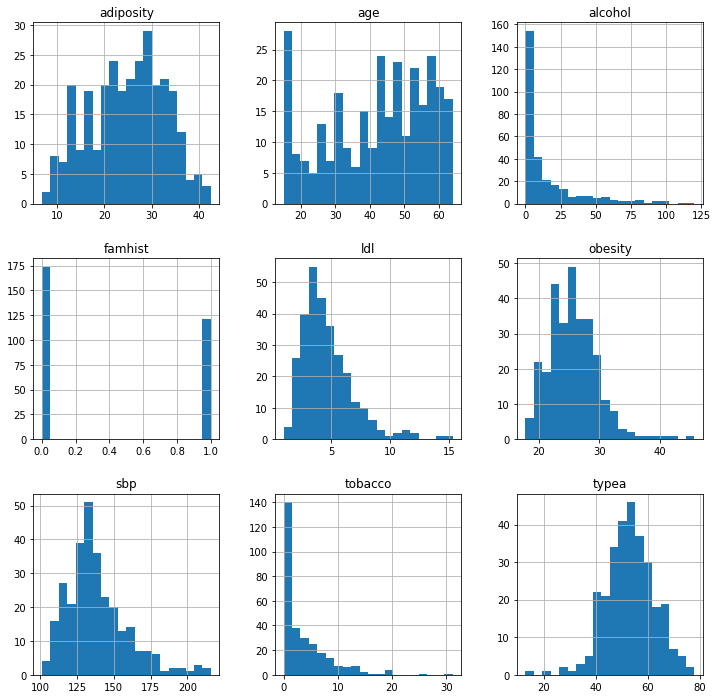

In [113]:
cardio.hist(bins = 20, figsize = (12,12))
plt.plot()

In [161]:
corr_matrix = cardio.corr()
corr_matrix['chd'].sort_values(ascending = False)

chd          1.000000
age          0.375376
tobacco      0.309451
famhist      0.277175
ldl          0.255865
adiposity    0.246497
sbp          0.125386
typea        0.094392
obesity      0.081873
alcohol      0.039519
row.names   -0.104864
Name: chd, dtype: float64

In [162]:
labels = cardio['chd']
cardio.drop('chd', axis = 1, inplace = True)

In [61]:
cardio.sample(6)

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age
384,126,19.60,6.03,34.99,0,49,26.99,55.89,44
3,170,7.50,6.41,38.03,1,51,31.99,24.26,58
444,142,3.00,3.69,25.10,0,60,30.08,38.88,27
45,128,4.65,3.31,22.74,0,62,22.95,0.51,48
325,156,0.00,3.47,21.10,0,73,28.40,0.00,36
432,136,0.00,4.00,19.06,0,40,21.94,2.06,16


In [163]:
num_attributes = ['age', 'tobacco', 'ldl', 'adiposity', 'sbp', 'alcohol', 'typea', 'obesity']
cat_attributes = ['famhist']

In [164]:
cardio_num = cardio[num_attributes]
cardio_cat = cardio['famhist']

In [165]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [166]:
def exclude_obesity(X, exclude = False):
    if exclude == True:
        X.drop('obesity', axis = 1, inplace = True)
    return X

In [167]:
def exclude_alcohol(X, exclude = False):
    if exclude == True:
        X.drop('alcohol', axis = 1, inplace = True)
    return X

In [168]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attributes)),
    ('exclude_obesity', FunctionTransformer(exclude_obesity, validate = False, 
                                           kw_args = {"exclude": True})),
    ('exclude_alcohol', FunctionTransformer(exclude_alcohol, validate = False,
                                           kw_args = {"exclude": True})),
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())
])

cardio_num_tr = pd.DataFrame(num_pipeline.fit_transform(cardio))

In [169]:
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attributes))
])

data_prep_pipeline = FeatureUnion(transformer_list=[
                    ("num_pipeline", num_pipeline),
                    ("cat_pipeline", cat_pipeline)])

In [170]:
cardio_prepared = pd.DataFrame(data_prep_pipeline.fit_transform(cardio))

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [133]:
cardio_prepared

,0,1,2,3,4,5,6
0,0.433217,-0.560052,-1.237518,1.169384,0.407631,-0.365672,0.0
1,-1.082017,-0.807472,-0.042666,-0.105952,0.509195,-0.365672,0.0
2,-1.770759,-0.786143,-0.735480,-1.824009,-0.303315,2.072237,0.0
3,-1.633011,-0.807472,-0.886091,-1.590071,-0.506443,1.224269,0.0
4,0.364343,0.088358,-0.921234,0.452479,0.102940,-1.107644,1.0
...,...,...,...,...,...,...,...
364,0.433217,-0.807472,-0.288665,1.425960,-0.303315,0.376300,0.0
365,0.846463,-0.636838,-1.142131,-0.968754,-1.522081,-0.683660,0.0
366,-0.186651,-0.461938,2.141201,-0.444281,-1.014262,0.588292,0.0
367,1.053086,0.062762,-0.077809,-1.337268,-1.217389,0.906281,1.0


In [ ]:
sns.pairplot(cardio_prepared)
plt.show()

### ML - model building


In [171]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, fbeta_score
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics.scorer import make_scorer

In [172]:
def get_scores(y_true, y_pred):
    
    def get_precision_score(y_true, y_pred):
        return precision_score(y_true, y_pred)
    
    def get_recall_score(y_true, y_pred):
        return recall_score(y_true, y_pred)
    
    def get_fbeta_score(y_true, y_pred):
        return fbeta_score(y_true, y_pred, beta = 2)
    
    print(f'precision   : {get_precision_score(y_true, y_pred)}')
    print(f'recall      : {get_recall_score(y_true, y_pred)}')
    print(f'fbeta score : {get_fbeta_score(y_true, y_pred)}')

In [173]:
fbeta_scorer = make_scorer(fbeta_score, beta = 1.414)

def get_fbeta_score(y_true, y_pred, beta = 1.414):
    return fbeta_score(y_true, y_pred, beta)

In [174]:
class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass

In [ ]:
# best_features = ([0, 1, 2], [0, 1, 2, 4, 6])

In [189]:
clf_pipeline = Pipeline([('clf', DummyEstimator())]) # placeholder estimator
param_grid = {
        'clf': [RandomForestClassifier(random_state = 0)],
        'clf__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
        'clf__max_features': ['auto', 'sqrt'],
        'clf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],
        'clf__bootstrap': [True, False]
}

random_search = RandomizedSearchCV(clf_pipeline, param_grid, cv = 5, verbose = 0, n_jobs = -1, 
                                      random_state = 0, n_iter = 10, scoring = fbeta_scorer)
best_clf = random_search.fit(cardio_prepared[[0, 1, 6]], labels)
print(random_search.best_score_)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.4887258968510158


In [190]:
pred_labels = best_clf.predict_proba(cardio_prepared[[0, 1, 2]])[:, 1] # probability of positive class

In [191]:
precisions, recalls, thresholds = precision_recall_curve(labels, pred_labels) 

In [192]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall") 
    plt.xlabel("Threshold") 
    plt.legend(loc="lower left") 
    plt.ylim([0, 1])

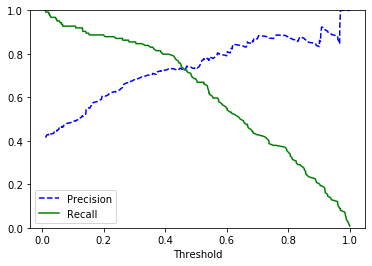

In [193]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds) 
plt.show()

In [194]:
probab_threshold = 0.45 # setting threshold at 0.4
pred_labels = np.where(pred_labels > probab_threshold, 1, 0)

In [195]:
get_scores(labels, pred_labels)

precision   : 0.7322834645669292
recall      : 0.75
fbeta score : 0.7463884430176565


### Evaluate on test set

In [205]:
test_labels = strat_test_set['chd']
strat_test_set.drop('chd', axis = 1, inplace = True)

In [206]:
cardio_test_prepared = pd.DataFrame(data_prep_pipeline.fit_transform(strat_test_set))

In [207]:
pred_test_labels = best_clf.predict_proba(cardio_test_prepared[[0, 1, 2]])[:, 1] 
pred_test_labels = np.where(pred_test_labels > probab_threshold, 1, 0)

In [208]:
get_scores(test_labels, pred_test_labels)

precision   : 0.5
recall      : 0.3888888888888889
fbeta score : 0.4069767441860465
